In [126]:
from IPython.display import clear_output

In [127]:
!pip install tensorflow
!pip install ipywidgets

clear_output()

In [128]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import tensorflow as tf
from ipywidgets import Button, Output
import random

In [129]:
# Baixando o conjunto de dados MNIST
mnist = tf.keras.datasets.mnist

# Carregando os dados de treinamento e teste
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Dados de treinamento:", X_train.shape, "Rótulos de treinamento:", y_train.shape)
print("Dados de teste:", X_test.shape, "Rótulos de teste:", y_test.shape)

Dados de treinamento: (60000, 28, 28) Rótulos de treinamento: (60000,)
Dados de teste: (10000, 28, 28) Rótulos de teste: (10000,)


* A classe real a ser prevista por nossa rede é do tipo discreto pertencente ao conjunto {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, sendo cada um deles representando um número de 0 à 9 referente ao numero desenhado na imagem.

In [130]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

* Cada dados de treinamento é uma imagem 28x28 pixels representados por uma matriz de 28x28, sendo cada elemento representando a cor de um pixel (0, 255). Para ser mais conveniente, "achataremos" nosso dado para que ele seja um array de 784 colunas (28*28), transformando nosso dataset de treinamento de 6000x28x28 para 6000x784. Faremos a mesma coisa com os dados de teste

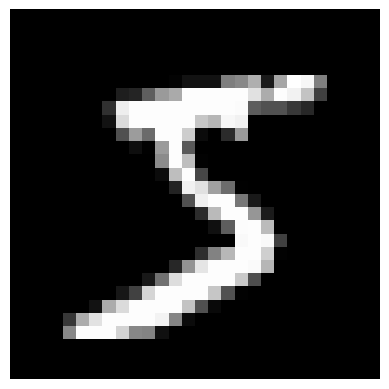

In [131]:
image = X_train[0].reshape(28, 28)

plt.imshow(image, cmap='gray')
plt.axis('off')  
plt.show()

In [132]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

In [133]:
X_train.shape

(60000, 784)

Iremos transpor nossos dados de entrada de forma que eles passem de 6000x784 para 784x6000. Dessa forma, cada atributo (pixel) será agora um exemplo (linha) e as novas colunas serão as imagens.

Mais a diante geraremos matrizes de pesos; para os pesos que conectam a camada de entrada à camada escondida por exemplo, geraremos uma matriz 10x784, em que cada linha representa os pesos conectados a um neurônio. Portanto para calcular o valor do corpo do neurônio $(Σwi * xi + b)$, faremos a multiplicação da matriz de pesos (Wh - 10x784) com a matriz de exemplos (X_train.T - 784x6000) somado ao bias (bh - 10x1), de forma que cada valor da matriz resultante será fruto da multiplicação de uma linha da matriz de pesos (wi) com uma coluna da matriz de exemplos (xi), acrescido de um bias.

In [134]:
lin, col = X_train.shape
n_output = len(set(y_train))
#np.random.shuffle(data)
X_train = X_train.T  # Cada atributo é um exemplo
X_test = X_test.T

Avaliaremos inicialmente com uma camada escondida com 10 neurônios e 10 neuônios também na camada de saída (1 para cada valor possível da nossa classe prevista)

In [135]:
n_hidden_layer_neurons = 10
n_output_layer_neurons = n_output  # 10, um neurônio para cada saída

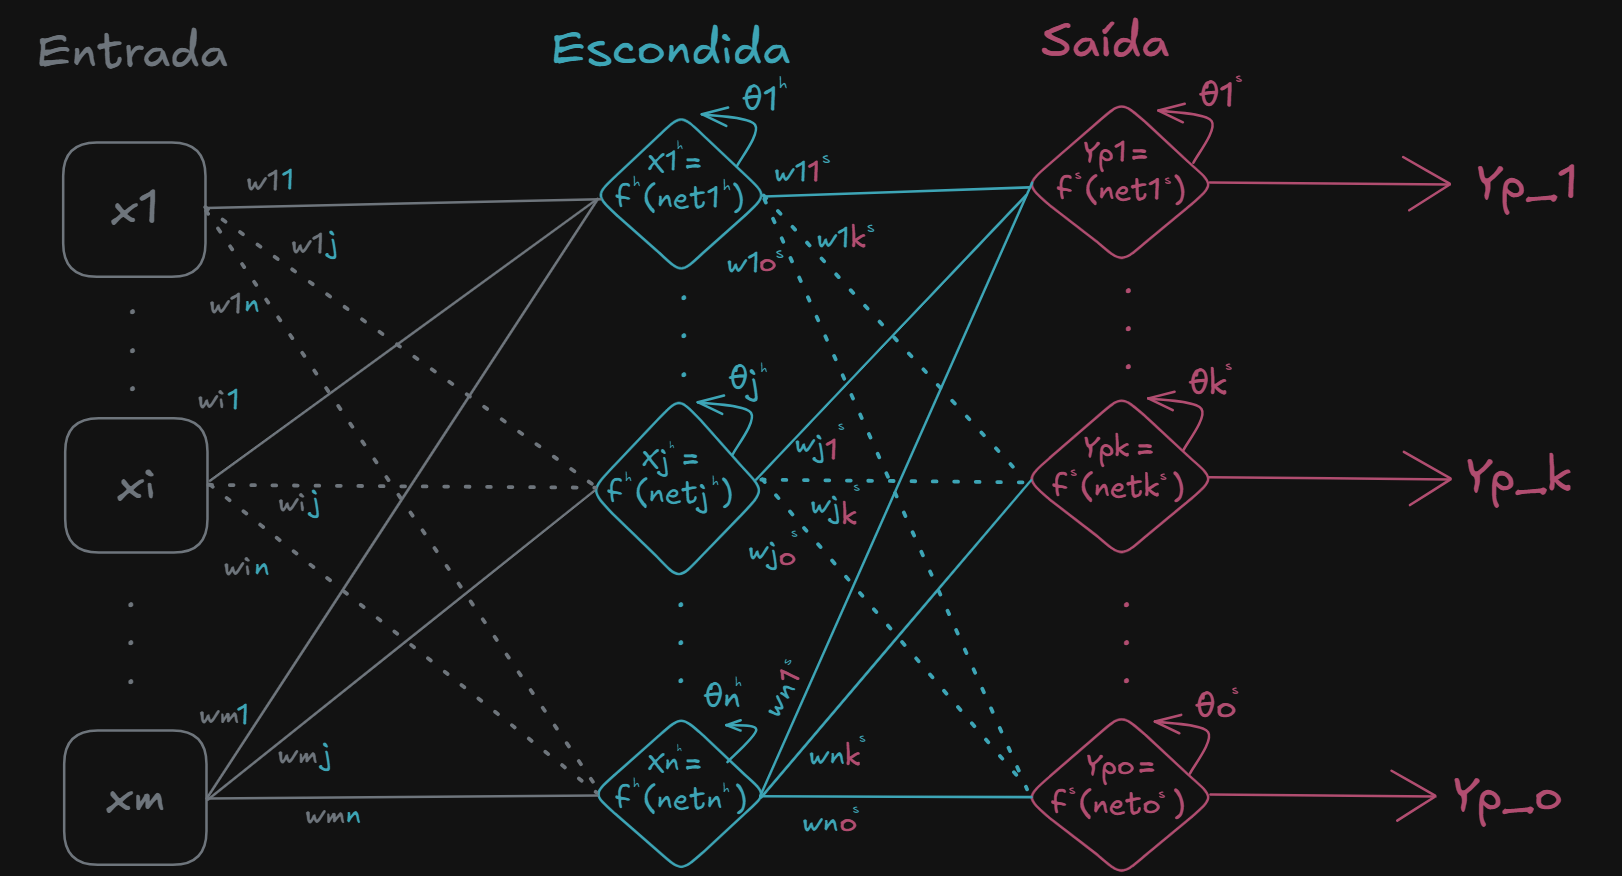

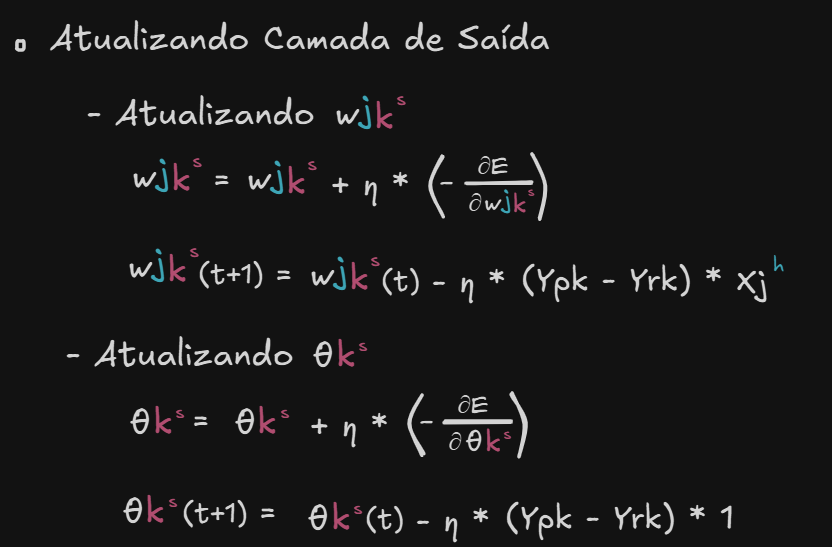

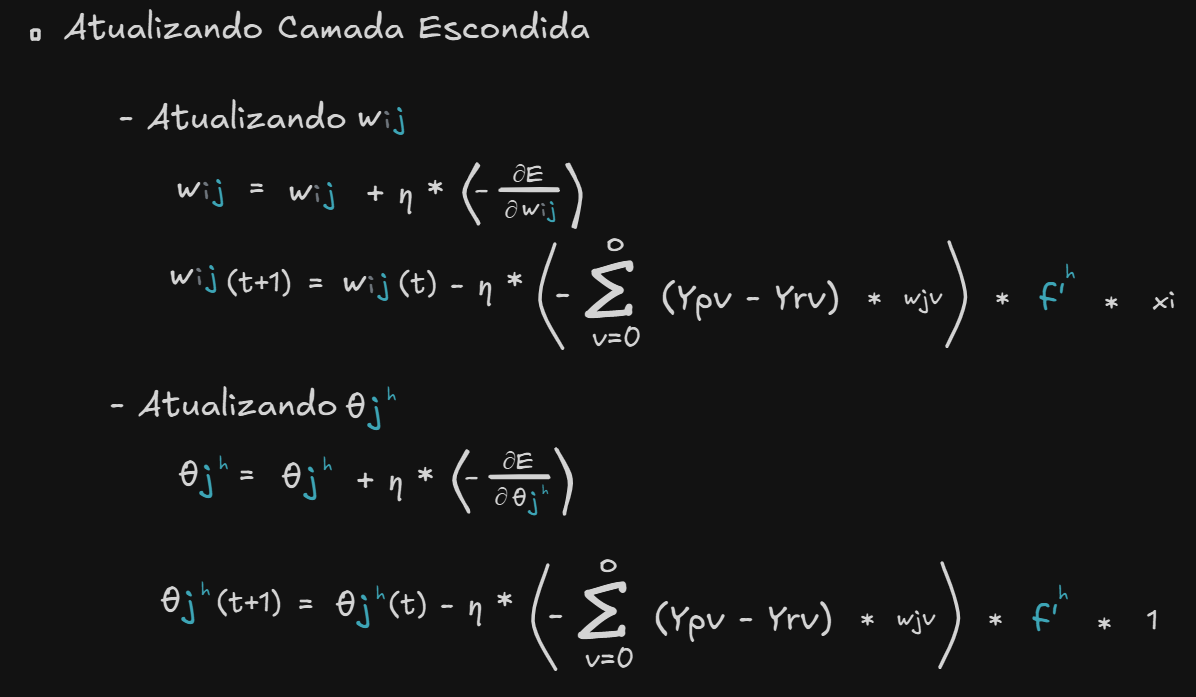

Usaremos Cross Entropy como função de erro, ReLU (Rectified Linear Unit) como função de ativação da camada escondida e Softmax como função de ativação da camada de saída.

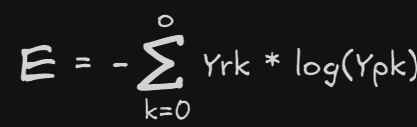

In [136]:
# Inicializando os pesos e bias com valores aleatórios entre -0.5 e 0.5
def init_params():
  Wh = np.random.rand(n_hidden_layer_neurons, col) - 0.5  # array de 10x784 de pesos aleatórios entre [-0.5, 0.5]
  bh = np.random.rand(n_hidden_layer_neurons, 1) - 0.5  # array de 10x1 de bias aleatórios entre [-0.5, 0.5]
  Ws = np.random.rand(n_output_layer_neurons, n_hidden_layer_neurons) - 0.5  # array de 10x10 de pesos aleatórios entre [-0.5, 0.5]
  bs = np.random.rand(n_output_layer_neurons, 1) - 0.5  # array de 10x1 de bias aleatórios entre [-0.5, 0.5]

  return Wh, bh, Ws, bs

$
\text{ReLU}(x) = \max(0, x) =
\begin{cases}
x & \text{se } x > 0 \\
0 & \text{se } x \leq 0
\end{cases}
$

A função sigmoidal tende a "esmagar" as ativações para valores muito negativos ou muito positivos de *x* (próximos de 0 ou 1), resultando em uma derivada (gradiente) que se aproxima de zero para essas entradas. Esse efeito resulta no problema do *vanishing gradient*, onde as atualizações dos pesos são muito pequenas durante o treinamento em redes profundas, tornando o processo de aprendizado lento ou até incapaz de avançar.

$sigma(x) = \frac{1}{1 + e^{-x}}$

A ReLU, por outro lado, mantém um gradiente constante (1) para valores positivos de x.

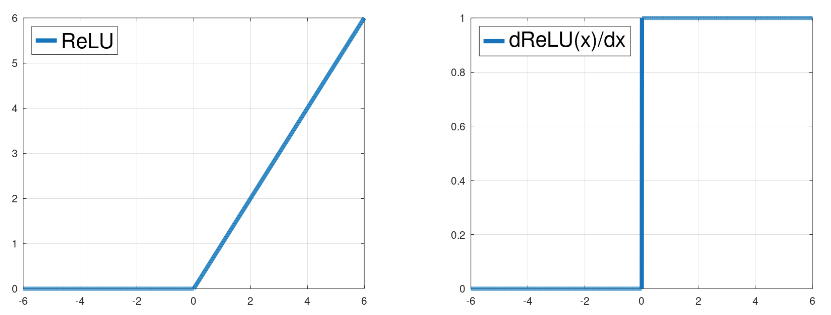

In [137]:
def ReLU(net):
  return np.maximum(net, 0)

A função de ativação *softmax* é comumente usada na camada de saída de redes neurais para problemas de classificação multiclasses. Ela transforma as saídas de uma rede em uma distribuição de probabilidade, onde cada valor representa a "probabilidade" da entrada pertencer a uma determinada classe.

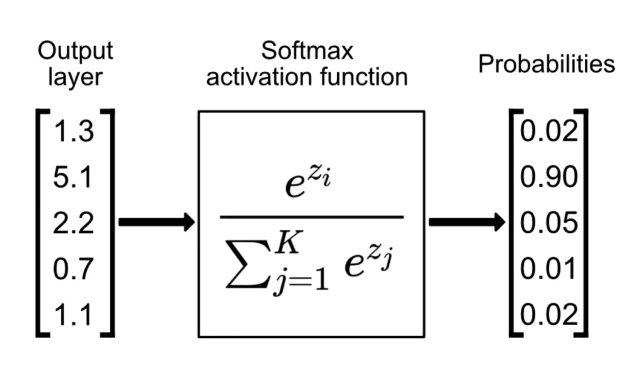

In [138]:
def softmax(net):
    f_neth = np.exp(net) / sum(np.exp(net))
    return f_neth

In [139]:
def feed_forward(Wh, bh, Ws, bs, X):
    neth = Wh.dot(X) + bh
    f_neth = ReLU(neth)
    Xh = f_neth  # Output da camada escondida
    nets = Ws.dot(Xh) + bs
    f_nets = softmax(nets)  # Output da camada de saída (Yp)
    return neth, f_neth, nets, f_nets

In [140]:
def one_hot_encoder(Y):
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))
    one_hot_Y[np.arange(Y.size), Y] = 1
    one_hot_Y = one_hot_Y.T
    return one_hot_Y

$
\text{ReLU′}(x) =
\begin{cases}
1 & \text{se } x > 0 \\
0 & \text{se } x \leq 0
\end{cases}
$

* Para valores de entrada $x > 0$: a derivada é 1, pois a função ReLU é linear com inclinação 1.

* Para $x ≤ 0$: a derivada é 0, porque a ReLU "trunca" todos os valores negativos para zero, e sua inclinação é zero nesses pontos.

In [141]:
def ReLU_deriv(neth):
    return neth > 0  # return True (1) if Xh > 0 else False (0)

In [142]:
def back_propagation(neth, f_neth, nets, f_nets, Wh, Ws, X, Y):
    m = Y.size
    one_hot_Y = one_hot_encoder(Y)
    Δabs_error = f_nets - one_hot_Y  # (Yp - Yr)
    dWs = 1 / m * Δabs_error.dot(f_neth.T)  # mean((Yp - Yr) * Xh)
    dbs = 1 / m * np.sum(Δabs_error) # mean((Ypj - Yrj))
    dZ1 = Ws.T.dot(Δabs_error) * ReLU_deriv(neth)  # Σ((Yrp - Ypr) * wjv) * f'h
    dWh = 1 / m * dZ1.dot(X.T)  # mean(dZ1 * xi)
    dbh = 1 / m * np.sum(dZ1)  # mean(dZ1)
    return dWh, dbh, dWs, dbs

In [143]:
def update_params(Wh, bh, Ws, bs, dWh, dbh, dWs, dbs, alpha):
    Wh = Wh - alpha * dWh  # atualizando os pesos da camada escondida
    bh = bh - alpha * dbh  # atualizando os bias da camada escondida
    Ws = Ws - alpha * dWs  # atualizando os pesos da camada de saída
    bs = bs - alpha * dbs  # atualizando os bias da camada de saída
    return Wh, bh, Ws, bs

In [144]:
"""
sendo ai uma imagem qualquer

            a1    a2    a3
f_nets = [[0.05, 0.91, 0.03],
          [0.89, 0.01, 0.12],
          [0.01, 0.02, 0.78],
           ...,  ...,   ... ]

cada coluna representará as probabilidades de uma amostra pertencer as classes de saída.
np.argmax(f_nets, axis=0) retornará o indice do maior valor de cada coluna. No caso do exemplo, [1, 0, 2]
"""
def get_predictions(f_nets):
    return np.argmax(f_nets, axis=0)

def get_accuracy(predictions, Y):
    return np.sum(predictions == Y) / Y.size

In [145]:
def gradient_descent(X, Y, alpha, iterations):
    Wh, bh, Ws, bs = init_params()  # inicializa os pesos e bias com valores aleatórios
    for i in range(iterations):
        neth, f_neth, nets, f_nets = feed_forward(Wh, bh, Ws, bs, X)  # feed forward
        dWh, dbh, dWs, dbs = back_propagation(neth, f_neth, nets, f_nets, Wh, Ws, X, Y)  # back propagation
        Wh, bh, Ws, bs = update_params(Wh, bh, Ws, bs, dWh, dbh, dWs, dbs, alpha)  # atualização dos pesos e bias
        if i % 10 == 0:  # monitoramento do progresso a cada 10 épocas
            print("Iteration: ", i)
            predictions = get_predictions(f_nets)
            print(get_accuracy(predictions, Y))
    return Wh, bh, Ws, bs

In [146]:
# Normalização das entradas por min-max para que haja convergência durante o treinamento
X_train = X_train / 255.0
X_test = X_test / 255.0

In [147]:
Wh, bh, Ws, bs = gradient_descent(X_train, y_train, 0.10, 500)

Iteration:  0
0.08151666666666667
Iteration:  10
0.20946666666666666
Iteration:  20
0.30556666666666665
Iteration:  30
0.41013333333333335
Iteration:  40
0.5023666666666666
Iteration:  50
0.5645833333333333
Iteration:  60
0.6076333333333334
Iteration:  70
0.6417
Iteration:  80
0.6673166666666667
Iteration:  90
0.6885
Iteration:  100
0.70565
Iteration:  110
0.7196
Iteration:  120
0.73155
Iteration:  130
0.7421666666666666
Iteration:  140
0.7514666666666666
Iteration:  150
0.7592333333333333
Iteration:  160
0.7659833333333333
Iteration:  170
0.7722833333333333
Iteration:  180
0.7784333333333333
Iteration:  190
0.7840333333333334
Iteration:  200
0.7897166666666666
Iteration:  210
0.7941333333333334
Iteration:  220
0.7981833333333334
Iteration:  230
0.8021833333333334
Iteration:  240
0.806
Iteration:  250
0.8092166666666667
Iteration:  260
0.8127
Iteration:  270
0.8155833333333333
Iteration:  280
0.8185833333333333
Iteration:  290
0.82155
Iteration:  300
0.8238333333333333
Iteration:  310


In [ ]:
def save_model(Wh, bh, Ws, bs, filename='trained_model.pkl'):
    model = {'Wh': Wh, 'bh': bh, 'Ws': Ws, 'bs': bs}
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    print(f"Modelo salvo em '{filename}'")

def load_model(filename='trained_model.pkl'):
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    print(f"Modelo carregado de '{filename}'")
    return model['Wh'], model['bh'], model['Ws'], model['bs']

# Salvar o modelo após o treinamento
save_model(Wh, bh, Ws, bs, 'trained_model.pkl')

In [117]:
def make_predictions(X, Wh, bh, Ws, bs):
    _, _, _, f_nets = feed_forward(Wh, bh, Ws, bs, X)
    predictions = get_predictions(f_nets)
    return predictions

def test_prediction(index, Wh, bh, Ws, bs):
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], Wh, bh, Ws, bs)
    label = y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Modelo carregado de 'trained_model.pkl'
Prediction:  [3]
Label:  5


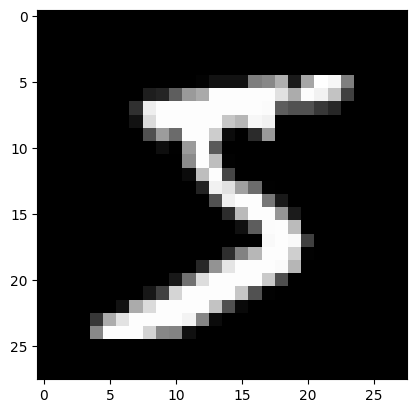

Prediction:  [0]
Label:  0


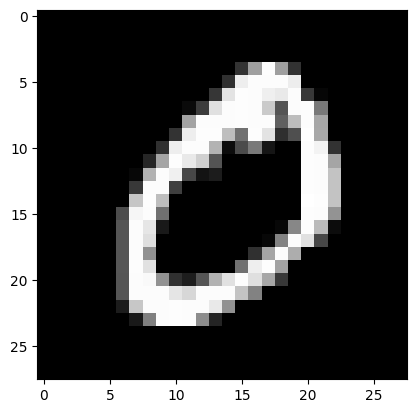

Prediction:  [4]
Label:  4


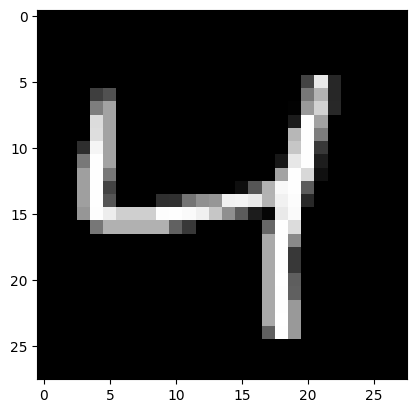

Prediction:  [1]
Label:  1


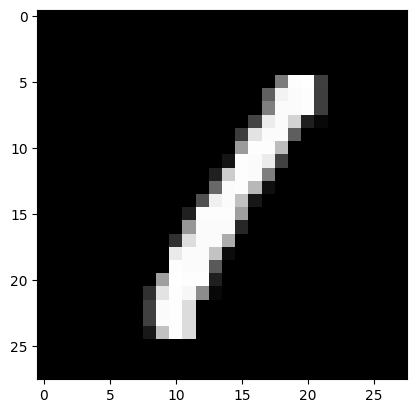

In [118]:
Wh, bh, Ws, bs = load_model('trained_model.pkl')

test_prediction(0, Wh, bh, Ws, bs)
test_prediction(1, Wh, bh, Ws, bs)
test_prediction(2, Wh, bh, Ws, bs)
test_prediction(3, Wh, bh, Ws, bs)

In [119]:
current_index = random.randint(0, len(X_test) - 1)

# Função para mostrar a imagem e a predição
def show_image(index):
    plt.clf()  
    current_image = X_test[:, index, None].reshape((28, 28)) * 255

    prediction = make_predictions(X_test[:, index, None], Wh, bh, Ws, bs)[0]
    label = y_test[index]

    if prediction == label:
        title_text = "Good"
        title_color = 'green'
    else:
        title_text = "Bad"
        title_color = 'red'

    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.title(title_text, fontsize=16, color=title_color, loc='center')
    
    plt.figtext(0.5, 0.8, f"Prediction: {prediction}, Label: {label}", color='white', ha="center", fontsize=12)
    plt.show()

btn_next = Button(description="Next")
output = Output()

def handle_next(_):
    global current_index
    current_index = random.randint(0, len(X_test) - 1)

    with output:
        clear_output()
        show_image(current_index)

btn_next.on_click(handle_next)

display(btn_next, output)

Button(description='Next', style=ButtonStyle())

Output()